## Data preparation



In [1119]:
import numpy as np 
import pandas as pd
import json  # Import the json module
from pandas import json_normalize
from sklearn.model_selection import train_test_split
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import get_dummies
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder



## Leser inn data


In [1120]:
df_hospital=pd.read_csv('raw_data/hospital.csv')

In [1121]:
df_physiological=pd.read_table('raw_data/physiological.txt')

##### Optimaliserer demographic filen 

In [1122]:
df_demographic=pd.read_csv('raw_data/demographic.csv')
df_demographic.columns

df_demographic.isnull().sum()

pasient_id       0
alder            0
kjønn            0
utdanning     1382
inntekt       2519
etnisitet       37
dtype: int64

In [1123]:
# Sjekk om det finnes noen tomme verdier i kolonnene kjønn og etnisitet
print(df_demographic[['kjønn', 'etnisitet']].isnull().sum())
#print(df_demographic.columns)

kjønn         0
etnisitet    37
dtype: int64


#### Må konvertere alle objektklassene til dummy-variabler.

In [1124]:
df_demographic=get_dummies(df_demographic, columns=['kjønn', 'etnisitet']) #dummify kjønn og etnisitet.
df_demographic['kjønn'] = df_demographic['kjønn_male'] #1 representerer mann og 0 representerer kvinne. 
df_demographic.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) #dropper de orginale kolonnene, og beholder de dummified.

#dimmmify inntekt, gjør om til numerisk verdi
income_mapping= {
    'under $11k': 0,
    '$11-$25k': 1,
    '$25-$50k': 2,
    '>$50k': 3,
}
df_demographic['inntekt']=df_demographic['inntekt'].map(income_mapping)
df_demographic=df_demographic.replace({True:1, False:0}) #gjør om boolean til numerisk verdi.
df_demographic['alder'] = df_demographic['alder'].apply(lambda x: x if x > 0 else np.nan)
df_demographic.isnull().sum()

/var/folders/m5/8gb8vdcj5x75zn4n6ccw73n40000gn/T/ipykernel_49031/2407383293.py:13: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



pasient_id               0
alder                    5
utdanning             1382
inntekt               2519
etnisitet_asian          0
etnisitet_black          0
etnisitet_hispanic       0
etnisitet_other          0
etnisitet_white          0
kjønn                    0
dtype: int64

In [1125]:
#Gjør om etnisitet til en kolonne

# Bruker idmax for å finne hvilken kolonne som har høyest verdi, og setter denne som etnisitet.
df_demographic['etnisitet'] = df_demographic[['etnisitet_white', 'etnisitet_black', 'etnisitet_asian', 'etnisitet_hispanic','etnisitet_other']].idxmax(axis=1)

etnisitet_mapping= {
    'etnisitet_white': 0,
    'etnisitet_black': 1,
    'etnisitet_asian': 2,
    'etnisitet_hispanic': 3,
    'etnisitet_other': 4,
    
}
# Bruker map() for å oversette kolonnenavnene til numeriske verdier
df_demographic['etnisitet'] = df_demographic['etnisitet'].map(etnisitet_mapping)

# Fjerner de gamle etnisitetskolonnene, hvis ønskelig
df_demographic.drop(columns=['etnisitet_white', 'etnisitet_black', 'etnisitet_asian', 'etnisitet_hispanic', 'etnisitet_other'], inplace=True)

# Nå har vi en kolonne 'etnisitet' med de korrekte numeriske verdiene
df_demographic.head()

,pasient_id,alder,utdanning,inntekt,kjønn,etnisitet
0,2,60.33899,12.0,1.0,0,0
1,3,52.74698,12.0,0.0,0,0
2,4,42.38498,11.0,0.0,0,0
3,5,79.88495,NaN,NaN,0,0
4,6,93.01599,14.0,NaN,1,0


#### Leser inn severity filen og optimaliserer, er en json fil.

In [1126]:
json_df=pd.read_json('raw_data/severity.json')


In [1127]:
#resonnomant
#explode ikke sykdomskategori-id, har ikke lister har kun et element. Likt som sykdomskategori,
#tar med de kun med liste og de som er viktige
#Optimaliserer, kan da slåes sammen med andre kategoriene. 
#explode brukes på kolonner som inneholder lister, for å få en rad per element i listen.

In [1128]:
df_severity=json_df.iloc[:,0:-1].explode(list(json_df.columns[2:-1])) #velger alle kolonner utenom siste, og henter navn på kolonner fra indeks 2 utenom siste.
#dette må vi gjøre for at alle kolonner skal bli med i explode og matche. 


df_severity.reset_index(drop=True,inplace=True)
df_severity=df_severity.sort_values(by=['pasient_id'], ignore_index=True)

df_severity['adl'] = df_severity[['adl_pasient', 'adl_stedfortreder']].mean(axis=1)
df_severity.drop(columns=['adl_pasient', 'adl_stedfortreder'], inplace=True)
#df_severity.head(20)

df_severity= pd.get_dummies(df_severity, columns=['kreft'])
df_severity.drop(columns=['sykdomskategori_id', 'sykdomskategori', 'kreft_no'], inplace=True, errors='ignore')

df_severity.loc[(df_severity['kreft_metastatic'] == 1), 'kreft_yes'] = True


dnr_mapping = {
    'dnr ved innleggelse': 2,
    'dnr før innleggelse': 1,
    'None': 0,
}

# Map DNR-status verdiene til numeriske verdier
df_severity['dnr_status'] = df_severity['dnr_status'].map(dnr_mapping)
df_severity['dnr_status'] = df_severity['dnr_status'].astype(float)

#df_severity.head(40) sjekker for å se at det blir riktig med metastatic og kreft_yes  
#df_severity 
print(df_severity.isnull().sum())



pasient_id                          0
dødsfall                            0
sykdom_underkategori                0
antall_komorbiditeter               0
koma_score                          0
fysiologisk_score                   0
apache_fysiologisk_score            0
overlevelsesestimat_2mnd            0
overlevelsesestimat_6mnd            0
diabetes                            0
demens                              0
lege_overlevelsesestimat_2mnd    1421
lege_overlevelsesestimat_6mnd    1407
dnr_status                       6670
adl                              1759
kreft_metastatic                    0
kreft_yes                           0
dtype: int64


#### Gjør om sykdom_underkategori til int/dummy-variabler

In [1129]:
encoder = OneHotEncoder(sparse_output=False, drop='first') 
encoded_data=encoder.fit_transform(df_severity[['sykdom_underkategori']])
encoded_columns = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['sykdom_underkategori']))
df_severity = pd.concat([df_severity, encoded_columns], axis=1)
df_severity.drop(['sykdom_underkategori'], axis=1, inplace=True)

df_severity.head()





,pasient_id,dødsfall,antall_komorbiditeter,koma_score,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,...,adl,kreft_metastatic,kreft_yes,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig
0,2,1,2,44.0,52.695312,74.0,0.001,0.0,0,0,...,1.0,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3,1,2,0.0,20.5,45.0,0.790894,0.664917,0,0,...,0.5,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4,1,2,0.0,20.097656,19.0,0.698975,0.411987,0,0,...,0.0,True,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0,1,26.0,23.5,30.0,0.634888,0.532959,0,0,...,2.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,1,1,55.0,19.398438,27.0,0.284973,0.214996,0,0,...,1.0,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Slår sammen tabellene

In [1130]:
#slår sammen og står med endelige dataFramen med alle data som vi vil jobbe etter. 
df=df_demographic.merge(df_hospital,on='pasient_id',how='outer')\
    .merge(df_physiological,on='pasient_id',how='outer')\
    .merge(df_severity,on='pasient_id',how='outer')
#df



In [1131]:
df = df.loc[df['oppholdslengde'] >= 0].reset_index(drop=True) #fjerne der opphold er ugyldig, aka minus. 

In [1132]:
df=df.drop_duplicates(subset=['pasient_id']).reset_index(drop=True) #fjerne duplikater

In [1133]:
# Setter pasient-id til indexen til dataframen
df.set_index('pasient_id', inplace=True)
df

,alder,utdanning,inntekt,kjønn,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,...,adl,kreft_metastatic,kreft_yes,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig
pasient_id,,,,,,,,,,,,,,,,,,,,,
2,60.33899,12.0,1.0,0,0,1,4,43.0,17.097656,112.0,...,1.0,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,52.74698,12.0,0.0,0,0,0,17,70.0,8.500000,88.0,...,0.5,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,42.38498,11.0,0.0,0,0,0,3,75.0,9.099609,88.0,...,0.0,True,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,93.01599,14.0,NaN,1,0,1,4,110.0,10.398438,101.0,...,1.0,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,62.37097,14.0,2.0,1,0,0,9,78.0,11.699219,120.0,...,0.5,False,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9101,66.07300,8.0,NaN,1,0,0,23,109.0,7.399414,104.0,...,0.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9102,55.15399,11.0,NaN,0,0,0,29,43.0,NaN,0.0,...,0.0,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9103,70.38196,NaN,NaN,1,0,0,8,111.0,8.398438,83.0,...,NaN,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Kategoriserer lungefunksjonen

In [1134]:
# Definerer gruppene og intervallene deres
bins=[0,100,200,300,np.inf]
labels=['Severe', 'Moderate', 'Mild', 'Normal']

# Bruker pd.cut til å kategoriserer, og map-er for å konverterer til numerisk alvorlighetsgrad direkte
severity_mapping = {'Severe': 3, 'Moderate': 2, 'Mild': 1, 'Normal': 0} 
df['lungfunction_mapped']=pd.cut(df['lungefunksjon'], bins=bins, labels=labels, right=False).map(severity_mapping)

#Fjerner den orginale kolonnen 'lungefunksjon'
df.drop(columns=['lungefunksjon'], inplace=True)
df.columns






Index(['alder', 'utdanning', 'inntekt', 'kjønn', 'etnisitet', 'sykehusdød',
       'oppholdslengde', 'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens',
       'respirasjonsfrekvens', 'kroppstemperatur', 'serumalbumin', 'bilirubin',
       'kreatinin', 'natrium', 'blod_ph', 'glukose', 'blodurea_nitrogen',
       'urinmengde', 'dødsfall', 'antall_komorbiditeter', 'koma_score',
       'fysiologisk_score', 'apache_fysiologisk_score',
       'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes',
       'demens', 'lege_overlevelsesestimat_2mnd',
       'lege_overlevelsesestimat_6mnd', 'dnr_status', 'adl',
       'kreft_metastatic', 'kreft_yes', 'sykdom_underkategori_CHF',
       'sykdom_underkategori_COPD', 'sykdom_underkategori_Cirrhosis',
       'sykdom_underkategori_Colon Cancer', 'sykdom_underkategori_Coma',
       'sykdom_underkategori_Lung Cancer', 'sykdom_underkategori_MOSF w/Malig',
       'lungfunction_mapped'],
      dtype='object')

In [1154]:
salary_nan_count = df['lungfunction_mapped'].isna().sum()

print(salary_nan_count)

1943


##### Gjør det samme for 'blod_ph', kategoriserer etter nomralverdiene (7.35-7.45)

In [1135]:
# LAger en ny kolonne med blod-ph-verdiene kategorisert , -1 dersom verdien er under normalen,
# 0 dersom verdien er normal, og 1 dersom verdien er over normalen.
df['blod_ph_kategorisert'] = pd.cut(df['blod_ph'],
                                    bins=[-float('inf'),7.35,7.45,float('inf')],
                                    labels=[-1,0,1])
df.drop(columns=['blod_ph'], inplace=True)

df.head()

,alder,utdanning,inntekt,kjønn,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,...,kreft_yes,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,lungfunction_mapped,blod_ph_kategorisert
pasient_id,,,,,,,,,,,,,,,,,,,,,
2,60.33899,12.0,1.0,0,0,1,4,43.0,17.097656,112.0,...,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,-1
3,52.74698,12.0,0.0,0,0,0,17,70.0,8.500000,88.0,...,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1
4,42.38498,11.0,0.0,0,0,0,3,75.0,9.099609,88.0,...,True,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN
6,93.01599,14.0,NaN,1,0,1,4,110.0,10.398438,101.0,...,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1
7,62.37097,14.0,2.0,1,0,0,9,78.0,11.699219,120.0,...,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


In [1155]:
blod_nan_count = df['blod_ph_kategorisert'].isna().sum()

print(salary_nan_count)

1943


#### Nå lurer jeg på blant annet hva er gjennomsnittlig oppholdslengde i dette datasettet er, max og min. 

In [1136]:
oppholdslenge_gjennomsnitt = df['oppholdslengde'].mean()
print(f"Gjennomsnittlig oppholdslengde: {oppholdslenge_gjennomsnitt}")
oppholdslengde_max = df['oppholdslengde'].max()
print(f"Den lengste oppholdslengden er: {oppholdslengde_max}")
oppholdslengde_min = df['oppholdslengde'].min()   
print(f"Den minste oppholdslengden er: {oppholdslengde_min}")


Gjennomsnittlig oppholdslengde: 17.819239720713732
Den lengste oppholdslengden er: 343
Den minste oppholdslengden er: 3


In [1137]:
#Endrer navn til enklere navn, lettere å jobbe med. 
df.rename(columns={'sykdom_underkategori_Coma': 'sykdom_Coma'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cancer': 'sykdom_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_COPD': 'sykdom_COPD'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_CHF': 'sykdom_CHF'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'}, inplace=True)




In [1138]:
df.columns

Index(['alder', 'utdanning', 'inntekt', 'kjønn', 'etnisitet', 'sykehusdød',
       'oppholdslengde', 'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens',
       'respirasjonsfrekvens', 'kroppstemperatur', 'serumalbumin', 'bilirubin',
       'kreatinin', 'natrium', 'glukose', 'blodurea_nitrogen', 'urinmengde',
       'dødsfall', 'antall_komorbiditeter', 'koma_score', 'fysiologisk_score',
       'apache_fysiologisk_score', 'overlevelsesestimat_2mnd',
       'overlevelsesestimat_6mnd', 'diabetes', 'demens',
       'lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd',
       'dnr_status', 'adl', 'kreft_metastatic', 'kreft_yes', 'sykdom_CHF',
       'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer', 'sykdom_Coma',
       'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'lungfunction_mapped',
       'blod_ph_kategorisert'],
      dtype='object')

In [1139]:
#dele i X og y
def split_X_y(df):
    return df.drop('oppholdslengde', axis=1), df['oppholdslengde']

X_train, y_train = split_X_y(train_df)
X_val, y_val = split_X_y(val_df)
X_test, y_test = split_X_y(test_df)



In [1140]:
#df_under_7_dager=df.loc[df['oppholdslengde']<=7].reset_index(drop=True)
#df_under_7_dager

## Visualisering

#### Visualisere sykdom, og vil se hvordan oppholdslengden er for hver sykdom 

In [1141]:
#Sjekker oppholdslengde i forhold til hver sykdomskategori
disease_cols = { 
       'kreft_metastatic', 'kreft_yes', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 
       'demens'
}

# Ensure all columns in disease_cols exist in train_df
disease_cols = [col for col in disease_cols if col in df.columns]

# Smelter dataframen til et langt format
disease_melted = pd.melt(df, 
                            id_vars=['oppholdslengde'], 
                            value_vars=disease_cols,
                            var_name='sykdom',
                            value_name='har_sykdom'
)
disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

#Plotter oppholdslengde i forhold til sykdomskategori
fig = px.box(disease_melted, 
             x='sykdom', 
             y='oppholdslengde',
             color='sykdom',
             title='Oppholdslengde i forhold til sykdomskategori',
             labels={'Oppholdslengde': 'Oppholdslengde (dager)', 'sykdom':'sykdom'},
             width=1300,
             height=1000
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

##### Visualisere fysiologisk score og oppholdslengde

##### Ser da at det er større sjangs for å overleve hvis man ikke har en høy fysiologisk score, kan indikere at jo lavere fysiologisk score man har jo kortere er man på sykehus, og friskerer er man. Ser også dette at hvis man har en veldig høy fysiologisk score når man blir lagt inn, så er det større sjangs for at man dør på sykehuset og har mindre opphold. 

In [1142]:
fig=px.scatter(df, x='fysiologisk_score', y='oppholdslengde', title= 'oppholdslengde i forhold til fysiologisk score',color='sykehusdød')
fig.show()

#### Lager en med fysiologisk score og hvilken sykdom dem har. 

##### Ser at det stemmer at sykdom ARF w sepsis er en sykdom som har tilfeller med høy fysiologisk score, som kan være med på at man er lengre på sykehus. Dette ser man har høy korrelasjon på korrelasjonen vi har laget lengre ned, at oppholdlengden øker med denne sykdommen. 

In [1143]:
#Sjekker oppholdslengde i forhold til hver sykdomskategori
# Ensure all columns in disease_cols exist in df
disease_cols = { 
       'kreft_metastatic', 'kreft_yes', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 
       'demens'
}
disease_cols = [col for col in disease_cols if col in df.columns]

# Smelter dataframen til et langt format
disease_melted = pd.melt(df, 
                         id_vars=['fysiologisk_score'], 
                         value_vars=disease_cols,
                         var_name='sykdom',
                         value_name='har_sykdom'
)
disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

#Plotter oppholdslengde i forhold til sykdomskategori
fig = px.box(disease_melted, 
             x='sykdom', 
             y='fysiologisk_score',
             color='sykdom',
             title='Fysiologisk score i forhold til sykdomskategori',
             labels={'Fysiologisk score': 'Fysiologisk score', 'sykdom':'sykdom'},
             width=1300,
             height=1000
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

In [1144]:
columns_to_exclude = ['pasient_id', 'aldersgrupper', 'utdanningsnivå']

'''
# Loop gjennom alle kolonnene i df
for col in train_df.columns:
    # Sjekk om kolonnen ikke er i listen over ekskluderte kolonner
    if col not in columns_to_exclude:
        # Lag og vis histogram
        fig = px.histogram(df, x=col, title=f'{col} histogram')
        #fig.show()
'''

"\n# Loop gjennom alle kolonnene i df\nfor col in train_df.columns:\n    # Sjekk om kolonnen ikke er i listen over ekskluderte kolonner\n    if col not in columns_to_exclude:\n        # Lag og vis histogram\n        fig = px.histogram(df, x=col, title=f'{col} histogram')\n        #fig.show()\n"

##### Lager en korrelasjon, for å se hva som korrelerer med 

#

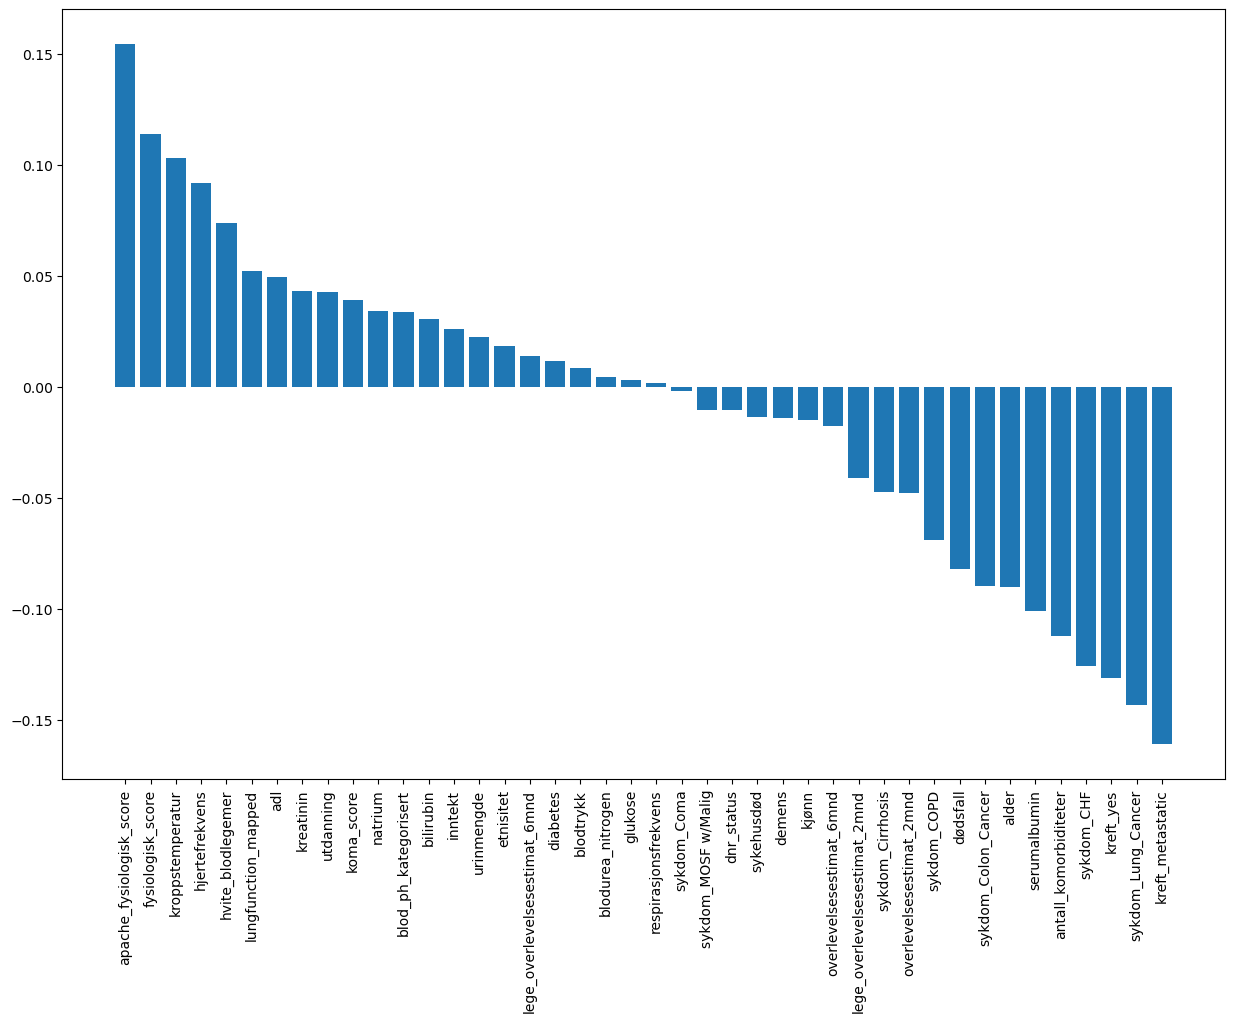

In [1145]:
correlation=df.corr()
corr_target=correlation['oppholdslengde'].sort_values(ascending=False)
corr_target.drop('oppholdslengde', inplace=True)

plt.figure(figsize=(15,10))
plt.bar(corr_target.index, corr_target.values)
plt.xticks(rotation=90)


plt.show()


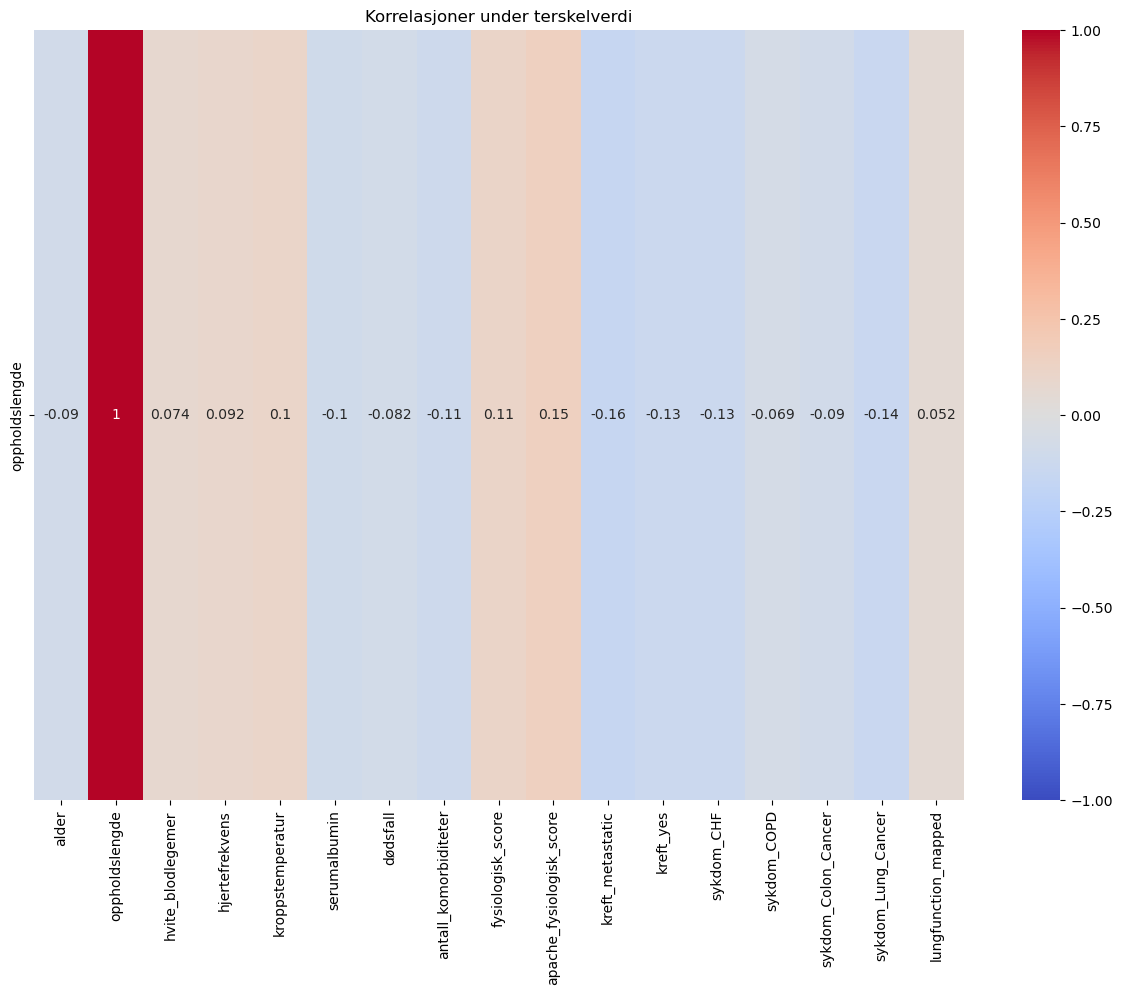

In [1146]:
oppholslengde_corr=correlation['oppholdslengde']
threshold=0.05
high_corr=oppholslengde_corr[np.abs(oppholslengde_corr)>=threshold]
low_corr=oppholslengde_corr[np.abs(oppholslengde_corr)<threshold]

plt.figure(figsize=(15,10))
sns.heatmap(high_corr.to_frame().T, annot=True, cmap='coolwarm',vmin=-1,vmax=1,cbar=True)
plt.title('Korrelasjoner under terskelverdi')
plt.show()

In [1147]:
# Litt dprlig å bruke korrelasjon når vi har binære og kontinuerlige variabler, men lar den stå for nå. 
# Den fanger opp linær antagelse, og sammenheng mellom to variabler. 
# Hvis du prøver å se sammenhengen mellom en sykdom (som er binær: tilstedeværende eller ikke tilstedeværende) 
# og antall dager på sykehuset (kontinuerlig), er ikke forholdet nødvendigvis lineært. 
# For eksempel kan det være en terskel hvor tilstedeværelsen av en sykdom kraftig øker oppholdslengden, men det er ikke en jevn økning.

correlation_matrix=df.corr()

fig =px.imshow(correlation_matrix,
               labels=dict(x='Features', y='Features', color='Correlation'),
               x=correlation_matrix.columns,
               y=correlation_matrix.columns,
                color_continuous_scale='RdBu_r',
                aspect='auto')

fig.update_layout(
    yaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),
    autosize=False,
    height=1000,
    width=1000

)
fig.show()

In [1148]:
#Når vi har fått puttet inn for NaN verider er det lurt å bruke mutual information for å se hvilke features som er viktigst.
# ettersom den korrelasjonen vi har brukt gjerne går glipp av, siden vi har linære og ikke linære sammenhenger.
# måler hvor mye informasjon en variabel gir oss om en annen. Den kan fange opp alle slags forhold, enten lineære eller ikke-lineære. 
'''
from sklearn.feature_selection import mutual_info_classif
import pandas as pd



X = train_df.drop(columns=['oppholdslengde'])  
y = train_df['oppholdslengde']  


mi = mutual_info_classif(X, y)


mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi
})


mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)


print(mi_df_sorted)
'''

"\nfrom sklearn.feature_selection import mutual_info_classif\nimport pandas as pd\n\n\n\nX = train_df.drop(columns=['oppholdslengde'])  \ny = train_df['oppholdslengde']  \n\n\nmi = mutual_info_classif(X, y)\n\n\nmi_df = pd.DataFrame({\n    'Feature': X.columns,\n    'Mutual Information': mi\n})\n\n\nmi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)\n\n\nprint(mi_df_sorted)\n"

## Lagrer den forberedte dataen som CSV-fil

In [1149]:
df.to_csv('prepared_data.csv', index=False)


## Model

In [1150]:
#Beskriver 
train_df.describe(include='all')

,alder,utdanning,inntekt,kjønn,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,...,kreft_yes,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,lungfunction_mapped,blod_ph_kategorisert
count,5413.000000,4435.000000,3620.000000,5413.000000,5413.000000,5413.000000,5413.000000,5413.000000,5281.000000,5413.000000,...,5413,5413.000000,5413.000000,5413.000000,5413.000000,5413.000000,5413.000000,5413.000000,4040.0,4059.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1409.0,2051.0
mean,62.667997,11.802480,0.936188,0.558470,0.313135,0.261777,17.883059,84.210881,12.411832,97.694624,...,NaN,0.147608,0.105487,0.052651,0.053944,0.068908,0.102900,0.080547,NaN,NaN
std,15.746510,3.421883,1.040524,0.496615,0.749259,0.439643,21.642808,27.700134,8.989788,31.487143,...,NaN,0.354743,0.307208,0.223356,0.225928,0.253321,0.303857,0.272163,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,52.790990,10.000000,0.000000,0.000000,0.000000,0.000000,6.000000,63.000000,7.000000,72.000000,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,65.008000,12.000000,1.000000,1.000000,0.000000,0.000000,11.000000,77.000000,10.699219,100.000000,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,74.107970,14.000000,2.000000,1.000000,0.000000,1.000000,20.000000,107.000000,15.398438,120.000000,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [1151]:
# Step 1: Prepare the feature matrix (X) and target vector (y)
X = train_df.drop('oppholdslengde', axis=1)
y = train_df['oppholdslengde']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Instantiate and train the RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
rfr.fit(X_train, y_train)

# Step 4: Use the score() method to get the R² score on test data
r2_score = rfr.score(X_test, y_test)

# Step 5: Print the R² score
r2_score

#tester på test data, jo høyere jo bedre. 
#r2 score forteller hvor godt modellen forklarer variasjonen i dataene. 16% ganske lavt. 

0.12423210576779575

In [1152]:
kolonne=X.columns
feature_scores = pd.Series(rfr.feature_importances_, index=kolonne).sort_values(ascending=False)
feature_scores

fysiologisk_score                0.076142
apache_fysiologisk_score         0.063595
overlevelsesestimat_6mnd         0.050746
alder                            0.047130
hvite_blodlegemer                0.046089
natrium                          0.043593
lungefunksjon                    0.043253
blodtrykk                        0.042343
kreatinin                        0.038768
bilirubin                        0.034984
kroppstemperatur                 0.034494
serumalbumin                     0.033307
glukose                          0.033120
respirasjonsfrekvens             0.033010
urinmengde                       0.032651
lege_overlevelsesestimat_2mnd    0.032495
hjertefrekvens                   0.031572
overlevelsesestimat_2mnd         0.031314
adl                              0.030508
utdanning                        0.028360
lege_overlevelsesestimat_6mnd    0.027088
koma_score                       0.024738
blodurea_nitrogen                0.018413
dnr_status                       0

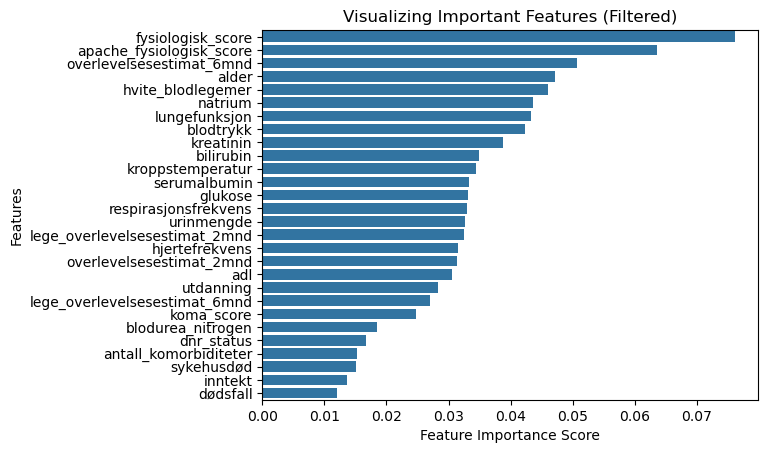

In [1153]:
# Define a threshold for feature importance
threshold = 0.01

# Filter features that have importance scores above the threshold
filtered_feature_scores = feature_scores[feature_scores > threshold]

# Create the seaborn bar plot using the filtered features
sns.barplot(x=filtered_feature_scores, y=filtered_feature_scores.index)

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features (Filtered)")

# Display the plot
plt.show()